<a href="https://colab.research.google.com/github/vitroid/GenIce-core/blob/main/example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## for Google Colaboratory

In [ ]:
%pip install git+https://github.com/vitroid/GenIce-core.git pairlist

## 1. Make an arbitrary graph directed.

In [ ]:
import networkx as nx
import matplotlib
import genice_core

g = nx.dodecahedral_graph()  # dodecahedral 20mer
pos = nx.spring_layout(g)

# set orientations of the hydrogen bonds.
dg = genice_core.ice_graph(g)

nx.draw_networkx(dg, pos)

## 2. And depolarized.

In [ ]:
import networkx as nx
import matplotlib
import genice_core
from logging import getLogger, DEBUG, basicConfig, INFO

basicConfig(level=INFO)
logger=getLogger()

g = nx.dodecahedral_graph()  # dodecahedral 20mer
pos = nx.spring_layout(g)

# set orientations of the hydrogen bonds.
# Minimize the net dipole moment.
dg = genice_core.ice_graph(g, pos, dipoleOptimizationCycles=100)

nx.draw_networkx(dg, pos)

## 3. Under the periodic boundary condition.

In [ ]:
from logging import DEBUG, INFO, basicConfig, getLogger

import networkx as nx
import numpy as np

# import py3Dmol
import pairlist
from genice_core import ice_graph

logger = getLogger()
basicConfig(level=INFO)

# a sample structure of ice 1h.
# The first line specifies the cell dimension, and atomic positions (absolute) follows.
pos = np.loadtxt("ice1h.txt").reshape(-1, 3)
cell, coords = pos[0], pos[1:]

# prepare the cell matrix
cellmat = np.diag(cell)

# make the fractional coordinates
fracCoords = coords / cell

# make a graph from the proximity
g = nx.Graph([(i, j) for i, j, _ in pairlist.pairs_iter(fracCoords, 0.3, cellmat)])

# set orientations of the hydrogen bonds.
dg = ice_graph(
    g, vertexPositions=fracCoords, isPeriodicBoundary=True, dipoleOptimizationCycles=100
)
dg

## Benchmark tests

### Scalability

INFO:root:Size 4
INFO:root:Distance between a cation and an anion: 4.
INFO:root:Depol. loop 999: [ 0.  0. -2.]
INFO:root:Depol. loop 2: [0. 0. 0.]
INFO:root:Depol. loop 1: [0. 0. 0.]
INFO:root:Depol. loop 999: [0. 0. 0.]
INFO:root:Depol. loop 2: [0. 0. 0.]
INFO:root:Depol. loop 999: [0. 0. 2.]
INFO:root:Failed to balance. Starting over ...
INFO:root:Depol. loop 62: [0. 0. 0.]
INFO:root:Depol. loop 10: [0. 0. 0.]
INFO:root:Depol. loop 6: [0. 0. 0.]
INFO:root:Failed to balance. Starting over ...
INFO:root:Depol. loop 4: [0. 0. 0.]
INFO:root:Size 4 Done.

INFO:root:Size 6
INFO:root:Distance between a cation and an anion: 6.
INFO:root:Failed to balance. Starting over ...
INFO:root:Failed to balance. Starting over ...
INFO:root:Depol. loop 999: [-5.55111512e-17 -1.11022302e-16  6.66666667e-01]
INFO:root:Failed to balance. Starting over ...
INFO:root:Failed to balance. Starting over ...
INFO:root:Depol. loop 999: [ 0.00000000e+00 -1.33226763e-15  6.66666667e-01]
INFO:root:Failed to balance. 

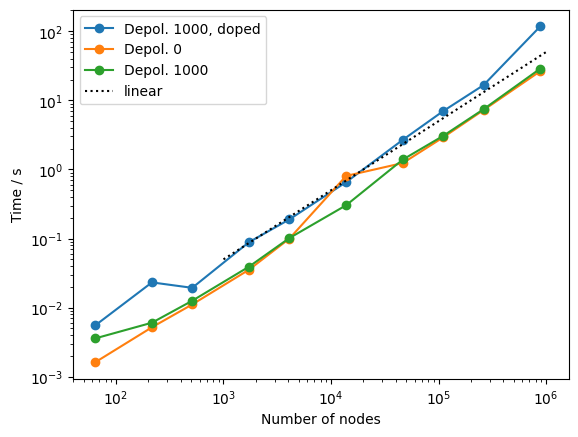

In [2]:
import pairlist as pl
import networkx as nx
import genice_core
import numpy as np
import time
import matplotlib.pyplot as plt
from logging import getLogger, basicConfig, INFO


def diamond(N: int) -> np.ndarray:
    """Diamond lattice. == ice 1c

    Args:
        N (int): Number of unit cells per an edge of the simulation cell.

    Returns:
        np.ndarray: atomic positions in the fractional coordinate.
    """
    # make an FCC
    xyz = np.array(
        [
            (x, y, z)
            for x in range(N)
            for y in range(N)
            for z in range(N)
            if (x + y + z) % 2 == 0
        ]
    )
    xyz = np.vstack([xyz, xyz + 0.5])
    return xyz / N


basicConfig(level=INFO)
logger = getLogger()

np.random.seed(998)

fig = plt.figure()

for doped, depol in (
    (True, 1000),
    (False, 0),
    (False, 1000),
):
    X = []
    Y = []
    for N in (4, 6, 8, 12, 16, 24, 36, 48, 64, 96):  # , 64, 96):
        logger.info(f"Size {N}")

        pos = diamond(N)
        cell = np.diag([N, N, N])

        # adjacency graph
        g = nx.Graph(
            [
                (i, j)
                for i, j in pl.pairs_iter(pos, 1, cell, fractional=True, distance=False)
            ]
        )

        fixed = nx.DiGraph()
        if doped:
            for nei in g[0]:
                fixed.add_edge(0, nei)
            c = len(g.nodes()) // 4
            pairDistance = nx.shortest_path_length(g, 0, c)
            logger.info(f"Distance between a cation and an anion: {pairDistance}.")
            for nei in g[c]:
                fixed.add_edge(nei, c)

        dt = []
        for i in range(10):
            now = time.time()
            dg = genice_core.ice_graph(
                g,
                vertexPositions=pos,
                dipoleOptimizationCycles=depol,
                isPeriodicBoundary=True,
                fixedEdges=fixed,
            )
            dt.append(time.time() - now)
        X.append(len(g))
        Y.append(np.mean(dt))
        logger.info(f"Size {N} Done.\n")

    plt.plot(X, Y, "o-", label=f"Depol. {depol}{', doped' if doped else ''}")

plt.xscale("log")
plt.yscale("log")
X = np.logspace(3, 6, 10)
Y = X / 20000
plt.plot(X, Y, "k:", label="linear")
plt.xlabel("Number of nodes")
plt.ylabel("Time / s")
plt.legend()
fig.savefig("Figure3.pdf")
fig.savefig("Figure3.png")

### Doped ice

Comparison with original GenIce 2.1 using Buch's algorithm.

In [ ]:
%pip install git+https://github.com/vitroid/GenIce.git#2.1.7.2

In [ ]:
! time genice2 1c -r 30 30 30 --cation 0=Li --anion 1000=F --depol=optimal > doped1c.gro
# 65 sec for stages 3 and 4 on Apple M1


In [ ]:
! time genice2 1c -r 30 30 30 --depol=strict > doped1c.gro
# 6 sec for stage 3D on Apple M1


In [ ]:
! pip install git+https://github.com/vitroid/GenIce.git@genice-core

In [ ]:
! time genice2 1c -r 30 30 30 --cation 0=Li --anion 1000=F --depol=optimal > doped1c.gro
# 15.8 sec for stage 34E on Apple M1


In [ ]:
! time genice2 1c -r 30 30 30 --depol=optimal > doped1c.gro
# 7.7 sec for stage 34E on Apple M1


In [ ]:
! pip install py3dmol

In [ ]:
! time genice2 1c -r 4 4 4 --cation 0=Li --anion 10=F --depol=optimal > doped1c.gro

In [ ]:
# なぜか表示されない
import py3Dmol

# show
view = py3Dmol.view()
view.addModel("doped1c.gro")
view.setStyle({'stick':{}})
view.addUnitCell()
view.zoomTo()
view.show()

### Normal ice

Improvement from GenIce2.1

In [ ]:
! pip install git+https://github.com/vitroid/GenIce.git#2.1.7.2
! time genice2 1c -r 30 30 30 > doped1c.gro

In [ ]:
! pip uninstall -y genice2
! pip install git+https://github.com/vitroid/GenIce.git@genice-core
! time genice2 1c -r 30 30 30 > doped1c.gro
! genice2 --version

## Debug and Tuning

In [ ]:
import pairlist as pl
import networkx as nx
import genice_core
import time
import matplotlib.pyplot as plt
from logging import getLogger, INFO, basicConfig

logger = getLogger()
basicConfig(level=INFO)


def main():
    np.random.seed(999)

    N = 64
    pos = diamond(N)
    cell = np.diag([N, N, N])
    # adjacency graph
    g = nx.Graph(
        [
            (i, j)
            for i, j in pl.pairs_iter(pos, 1, cell, fractional=True, distance=False)
        ]
    )

    now = time.time()
    dg = genice_core.ice_graph(
        g,
        vertexPositions=pos,
        dipoleOptimizationCycles=100,
    )


import cProfile

cProfile.run("main()", filename="main.prof")

In [ ]:
import pstats

sts = pstats.Stats("main.prof")
sts.strip_dirs().sort_stats(-1).print_stats()

In [ ]:
import networkx as nx
import matplotlib
import genice_core
from logging import getLogger, DEBUG, basicConfig, INFO
import numpy as np

basicConfig(level=INFO)
logger = getLogger()

np.random.seed(999)

g = nx.dodecahedral_graph()  # dodecahedral 20mer
pos = nx.spring_layout(g)

fixed = nx.DiGraph(
    [
        [0, 1],
    ]
)

# set orientations of the hydrogen bonds.
# Minimize the net dipole moment.
dg = genice_core.ice_graph(
    g,
    pos,
    dipoleOptimizationCycles=100,
    fixedEdges=fixed,
)

nx.draw_networkx(dg, pos)